<a href="https://colab.research.google.com/github/UEPP40/PUM/blob/paziewski/System_rekomendacyjny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Przegląd danych:

1.Podaj liczbę filmów dla dzieci

2.Pokaż rozkład ocen filmów z 1995

3.Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej oceniane

In [17]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
5       1       70     3.0  964982400
6       1      101     5.0  964980868
7       1      110     4.0  964982176
8       1      151     5.0  964984041
9       1      157     5.0  964984100
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                               

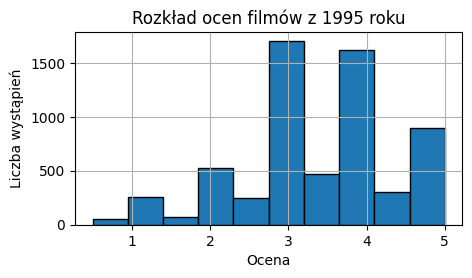

Średnia ocena filmów akcji: 3.447984331646809
3 najwyżej oceniane filmy akcji:
title
Knock Off (1998)                                                      5.0
On the Other Side of the Tracks (De l'autre côté du périph) (2012)    5.0
Sonatine (Sonachine) (1993)                                           5.0
Name: rating, dtype: float64


In [24]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')
print(ratings.head(10))
print(movies.head(10))


# Połącz zestawy danych na podstawie movieId
data_merged = pd.merge(ratings, movies, on='movieId')
print(data_merged.head(10))

# Zadanie 1: Liczba filmów dla dzieci
children_movies_count = movies[movies['genres'].str.contains('Children')].shape[0]
print("Liczba filmów dla dzieci: " + str(children_movies_count))

# Zadanie 2: Rozkład ocen filmów z 1995 roku
movies_1995 = movies[movies['title'].str.contains('\(1995\)')]
data_1995 = data_merged[data_merged['movieId'].isin(movies_1995['movieId'])]
print(f"Rozkład ocen filmów z 1995 roku:\n{data_1995['rating'].describe()}")

# Wykres rozkładu ocen filmów z 1995 roku
plt.figure(figsize=(5, 2.5))
plt.hist(data_1995['rating'], bins=10, edgecolor='black')
plt.title('Rozkład ocen filmów z 1995 roku')
plt.xlabel('Ocena')
plt.ylabel('Liczba wystąpień')
plt.grid(True)
plt.show()

# Zadanie 3: Średnia ocena wszystkich filmów akcji oraz 3 najwyżej oceniane filmy
action_movies = movies[movies['genres'].str.contains('Action')]
data_action = data_merged[data_merged['movieId'].isin(action_movies['movieId'])]
average_action_rating = data_action['rating'].mean()
top_3_action_movies = data_action.groupby('title')['rating'].mean().sort_values(ascending=False).head(3)

print(f"Średnia ocena filmów akcji: {average_action_rating}")
print("3 najwyżej oceniane filmy akcji:")
print(top_3_action_movies)

Zbuduj system rekomendacyjny używając biblioteki SURPRISE

• Użyj dwóch algorytmów SVD oraz kNN w wersji wylosowanej

• Użyj optymalizacji parametrów metodą GRID search do wyboru liczby sąsiadów z wylosowanego przedziału

• Użyj walidacji krzyżowej dla ostatecznego modelu

• Porównaj oba algorytmy pod względem czasu uczenia oraz wylosowanych błędów

In [27]:
!pip install surprise
# importing relevant libraries
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise import Dataset
from surprise import Reader
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split
import time

In [28]:
# Wczytaj dane
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

# Przygotowanie danych
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

# Algorytm SVD
start_time_svd_train = time.time()
algo_svd = SVD()
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)
svd_rmse = accuracy.rmse(predictions_svd)
end_time_svd_train = time.time()

param_grid_svd = {'n_factors': [10, 20, 50, 100], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3, n_jobs=-1)
start_time_svd = time.time()
gs_svd.fit(data)
end_time_svd = time.time()

# Algorytm kNN
start_time_knn_train = time.time()
algo_knn = KNNBasic()
algo_knn.fit(trainset)
predictions_knn = algo_knn.test(testset)
knn_rmse = accuracy.rmse(predictions_knn)
end_time_knn_train = time.time()

param_grid_knn = {'k': [20, 30, 40, 50], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]}}
gs_knn = GridSearchCV(KNNBasic, param_grid_knn, measures=['rmse'], cv=3, n_jobs=-1)
start_time_knn = time.time()
gs_knn.fit(data)
end_time_knn = time.time()

# Najlepsze parametry dla SVD i kNN
best_svd_params = gs_svd.best_params['rmse']
best_knn_params = gs_knn.best_params['rmse']

# Walidacja krzyżowa dla najlepszych modeli
best_svd = gs_svd.best_estimator['rmse']
best_knn = gs_knn.best_estimator['rmse']

# Walidacja krzyżowa dla kNN
start_time_knn_cross = time.time()
cv_results_knn = cross_validate(best_knn, data, measures=['rmse'], cv=5, verbose=True)
end_time_knn_cross = time.time()

# Walidacja krzyżowa dla SVD
start_time_svd_cross = time.time()
cv_results_svd = cross_validate(best_svd, data, measures=['rmse'], cv=5, verbose=True)
end_time_svd_cross = time.time()

# Wyniki
print(f"\nNajlepsze parametry SVD: {best_svd_params}")
print(f"Najlepsze parametry kNN: {best_knn_params}")
print(f"\nCzas trenowania SVD: {end_time_svd_train - start_time_svd_train:.2f} sekund")
print(f"Czas trenowania kNN: {end_time_knn_train - start_time_knn_train:.2f} sekund")
print(f"\nCzas optymalizacji hiperparametrów SVD: {end_time_svd - start_time_svd:.2f} sekund")
print(f"Czas optymalizacji hiperparametrów kNN: {end_time_knn - start_time_knn:.2f} sekund")
print(f"\nCzas walidacji krzyżowej SVD: {end_time_svd_cross - start_time_svd_cross:.2f} sekund")
print(f"Czas walidacji krzyżowej kNN: {end_time_knn_cross - start_time_knn_cross:.2f} sekund")

print("\nWyniki walidacji krzyżowej dla SVD:")
for key, value in cv_results_svd.items():
    print(f"{key}: {value}")

print("\nWyniki walidacji krzyżowej dla kNN:")
for key, value in cv_results_knn.items():
    print(f"{key}: {value}")

RMSE: 0.8750
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9553
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9199  0.9130  0.9139  0.9165  0.9187  0.9164  0.0027  
Fit time          7.94    8.74    8.87    8.71    12.38   9.33    1.56    
Test time         10.27   9.91    9.9